In [1]:
!pip install pennylane --quiet
!pip install numpy --quiet
!pip install tensorflow --quiet
!pip install matplotlib --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 22.8 MB/s eta 0:00:00


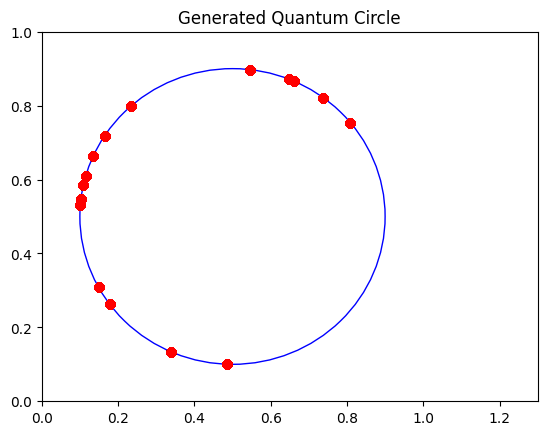

In [42]:
import pennylane as qml
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Define the number of qubits and number of quantum layers
num_qubits = 2
num_layers = 2

# Create the quantum device
dev = qml.device("default.qubit", wires=num_qubits)

# Quantum circuit definition
# Make the funtion a quantum node (via QNode)
@qml.qnode(dev)
def quantum_neural_net(inputs, weights):
    qml.Hadamard(wires=0)
    qml.CNOT(wires=[0,1])

    # Encode the to Qubits
    for i in range(num_qubits):
        qml.RY(weights[i], wires=i)

    # Sequence of Variational Training Layers
    for i in range(num_layers):
      for j in range(num_qubits):
        qml.RX(weights[i], wires=j)
    qml.CNOT(wires = [0,1])
    # Measures the expectation value of the 'PauliZ()' operator to get a value
    # between -1 and 1
    return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1))

# Classical neural network (placeholder for simplicity)
# Performs the matric multiplication between the inputs and weights, creating
# a neural network.
def classical_neural_net(inputs, weights):
    return tf.matmul(inputs, weights)

# Hybrid model combining quantum and classical parts
def hybrid_model(inputs, q_weights, c_weights):
    q_output = quantum_neural_net(inputs, q_weights)
    c_output = classical_neural_net(inputs, c_weights)
    return q_output + c_output

# Loss function calculates the loss of the hybrid model. This is down with mean
# squared error between the real parts and the target values.
def loss(q_weights, c_weights):
    predictions = hybrid_model(inputs, q_weights, c_weights)
    predictions_real = tf.math.real(predictions)
    return tf.reduce_mean(tf.square(predictions_real - target_real))

# Initialize random weights for the classcial and quantum neural networks.
q_weights = tf.Variable(np.random.random((num_layers, num_qubits)), dtype=tf.float64)
c_weights = tf.Variable(np.random.random((num_layers, 2)), dtype=tf.float64)

# Define inputs and target (unit circle coordinates)
inputs = np.random.uniform(0, 2*np.pi, size=(16, 2))
target = np.array(np.linspace(0, 2*np.pi, 16, endpoint=True), dtype=np.complex128)
target = np.vstack((target, target))
target_real = np.real(target.T)

# Optimization using Adam function to minimize the loss. over the X amount of
# steps the optimizer will update the gradients
opt = tf.keras.optimizers.Adam(learning_rate=0.4)
steps = 200

for _ in range(steps):
    with tf.GradientTape() as tape:
        current_loss = loss(q_weights, c_weights)

    gradients = tape.gradient(current_loss, [q_weights, c_weights])
    opt.apply_gradients(zip(gradients, [q_weights, c_weights]))

# After optimization, q_weights and c_weights will be updated
predictions = hybrid_model(inputs, q_weights, c_weights)


# Plots ideal circle and the results
def plot_circle(theta_final):
    fig, ax = plt.subplots()
    circle = plt.Circle((0.5, 0.5), 0.4, color='blue', fill=False)
    ax.add_artist(circle)
    plt.xlim(0, 1.3)
    plt.ylim(0, 1)
    plt.yscale('linear')
    plt.xscale('linear')
    plt.title('Generated Quantum Circle')

    # Generate points using the final parameters
    points = []
    for i in range(100):
        x = 0.5 + 0.4 * np.cos(predictions)
        y = 0.5 + 0.4 * np.sin(predictions)
        points.append([x, y])

    points = np.array(points)

    # Plot the points
    plt.scatter(points[:, 0], points[:, 1], color='red')

    plt.show()

plot_circle(predictions)